In [78]:
# Stop warnings
import warnings
warnings.filterwarnings('ignore')

# general import
import os 
import sys
import glob
import json
import scipy
import cortex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import r2_score


# GLMsingle
from glmsingle.glmsingle import GLM_single
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish 


# Nilearn
from nilearn.plotting import plot_design_matrix 
from nilearn.glm.first_level import make_first_level_design_matrix

# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from glm_utils import eventsMatrix, extract_predictions_r2
from surface_utils import load_surface, make_surface_image
from pycortex_utils import set_pycortex_config_file

In [4]:
# main_dir = '/Users/uriel/disks/meso_shared'
# code_dir = '/Users/uriel/disks/meso_H/projects'

main_dir = '/home/ulascombes/disks/meso_shared'
code_dir = '/home/ulascombes/disks/meso_H/projects'



project_dir = 'RetinoMaps'
subject = 'sub-02'
run = 'run-02'
task = 'SacLoc'

In [5]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

In [6]:
# load settings
with open('/{}/{}/analysis_code/settings.json'.format(code_dir,project_dir)) as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
TR = analysis_info['TR']
TRs = analysis_info['TRs']
glm_alpha = analysis_info['glm_alpha']
tasks = analysis_info['task_glm']
func_session = analysis_info['func_session'][0]
formats = analysis_info['formats']
extensions = analysis_info['extensions']
confounds_list = analysis_info['glm_confounds']

# Designe matrix

In [7]:
def make_design(events, tr, n_times, hrf=None):
    """generate either a blip design or one convolved with an hrf

    Args:
        events ([type]): [description]
        tr ([type]): [description]
        n_times ([type]): [description]
        hrf ([type], optional): Defaults to None. [description]

    Returns:
        [type]: [description]
    """

    # loop over conditions
    conditions = np.unique(events.trial_type)
    n_conditions = len(set(events['trial_type'].values))

    dm = np.zeros((n_times, n_conditions))

    if hrf is None:
        for i, cond in enumerate(conditions):

            # onset times for qth condition in run p
            otimes = np.array(
                (events[events['trial_type'] == cond]['onset'].values//tr)).astype(int)
            yvals = np.zeros((n_times))
            for r in otimes:
                yvals[r] = 1
            dm[:, i] = yvals

    else:
        # calc
        all_times = np.linspace(0, tr*(n_times-1), n_times)
        hrf_times = np.linspace(0, tr*(len(hrf)-1), len(hrf))

        for i, cond in enumerate(conditions):
            # onset times for qth condition in run p
            otimes = events[events['trial_type'] == cond]['onset'].values

            # intialize
            yvals = np.zeros((n_times))

            # loop over onset times
            for r in otimes:
                # interpolate to find values at the data sampling time points
                f = pchip(r + hrf_times, hrf, extrapolate=False)(all_times)
                yvals = yvals + np.nan_to_num(f)

            # record
            dm[:, i] = yvals

    return dm

In [8]:
event_dir = '{}/{}/{}/{}/func'.format(main_dir,project_dir,subject,func_session)
event_file = glob.glob("{}/{}_{}_task-{}_{}_events.tsv".format(event_dir, 
                                                               subject, 
                                                               func_session, 
                                                               task, 
                                                               run))
events = eventsMatrix(design_file=event_file[0], task=task, tr=TR)

In [9]:
frame_times = np.arange(TRs) * TR

# first dimention contain the design for 'Fix' and second dimension contain the designe for the eye mvt task
design_matrix = make_design(events=events, tr=TR, n_times=TRs)

In [10]:
# extract only the design for the eye mvt task 
design_matrix_reshaped = design_matrix[:,1].reshape(-1,1)

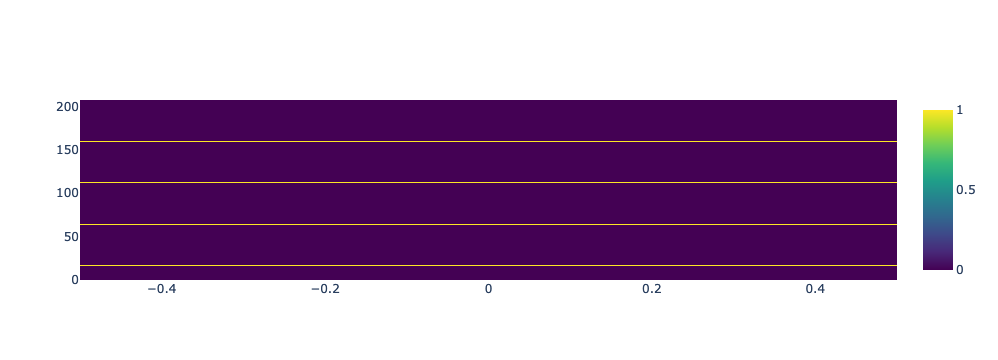

In [11]:
fig = go.Figure(data=go.Heatmap(z=design_matrix_reshaped, colorscale="Viridis"))

# Afficher la heatmap
fig.show()

# GLM Single 

## Load data 

In [12]:
dct_dir = '{}/{}/derivatives/pp_data/{}/fsnative/func/fmriprep_dct'.format(main_dir, 
                                                                           project_dir, 
                                                                           subject)

dct_L_fn = '{}_{}_task-{}_{}_hemi-L_space-fsnative_dct_bold.func.gii'.format(subject, 
                                                                             func_session, 
                                                                             task, 
                                                                             run)

dct_R_fn = '{}_{}_task-{}_{}_hemi-R_space-fsnative_dct_bold.func.gii'.format(subject, 
                                                                             func_session, 
                                                                             task, 
                                                                             run)

In [13]:
img_dct_bold_L, data_dct_bold_L = load_surface(fn='{}/{}'.format(dct_dir,dct_L_fn))

In [14]:
dct_L_fn_run_1= '{}_{}_task-{}_run-01_hemi-L_space-fsnative_dct_bold.func.gii'.format(subject, 
                                                                             func_session, 
                                                                             task)
dct_L_fn_run_2= '{}_{}_task-{}_run-02_hemi-L_space-fsnative_dct_bold.func.gii'.format(subject, 
                                                                             func_session, 
                                                                             task)

In [15]:
img_dct_bold_L_run_1, data_dct_bold_L_run_1 = load_surface(fn='{}/{}'.format(dct_dir,dct_L_fn_run_1))
img_dct_bold_L_run_2, data_dct_bold_L_run_2 = load_surface(fn='{}/{}'.format(dct_dir,dct_L_fn_run_2))

In [16]:
data_dct_bold_L_run_2.shape

(208, 147618)

In [17]:
data_multi_run = [data_dct_bold_L_run_1.T, data_dct_bold_L_run_2.T]
design_multi_run = [design_matrix_reshaped, design_matrix_reshaped]

In [90]:
data_multi_run[0].shape

(147618, 1, 1, 208)

In [19]:
data_dct_bold_L_run_1.shape

(208, 147618)

## Initialize the model

In [20]:
# create a directory for saving GLMsingle outputs
# outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)


# Fit the model 

In [21]:
# outputdir = '/Users/uriel/Desktop/dossier sans titre'
outputdir = '/home/ulascombes/glm_single'

stimdur= 38.4

results_glmsingle = glmsingle_obj.fit(
   # design=design_matrix_reshaped,
   # data=data_dct_bold_L.T,
    design=design_multi_run,
   data=data_multi_run,
   stimdur=stimdur,
   tr=TR,
   outputdir=outputdir, 
    figuredir=outputdir)

*** DIAGNOSTICS ***:
There are 2 runs.
The number of conditions in this experiment is 1.
The stimulus duration corresponding to each trial is 38.40 seconds.
The TR (time between successive data points) is 1.20 seconds.
The number of trials in each run is: [4, 4].
The number of trials for each condition is: [8].
For each condition, the number of runs in which it appears: [2].
For each run, how much ending buffer do we have in seconds? [56.4, 56.4].
*** Saving design-related results to /home/ulascombes/glm_single/DESIGNINFO.npy. ***
*** FITTING DIAGNOSTIC RUN-WISE FIR MODEL ***
*** Saving FIR results to /home/ulascombes/glm_single/RUNWISEFIR.npy. ***

*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /home/ulascombes/glm_single/TYPEA_ONOFF.npy. ***

*** Setting brain R2 threshold to 1.8467375339462735 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 3/3 [01:10<00:00, 23.58s/it]



*** Saving results to /home/ulascombes/glm_single/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks: 100%|██████████| 3/3 [00:36<00:00, 12.00s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 3/3 [00:18<00:00,  6.30s/it]



*** Saving results to /home/ulascombes/glm_single/TYPEC_FITHRF_GLMDENOISE.npy. ***

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 3/3 [04:33<00:00, 91.03s/it]


*** Saving results to /home/ulascombes/glm_single/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***



# Pycortex maps with results 

In [22]:
results_glmsingle.keys()

dict_keys(['typea', 'typeb', 'typec', 'typed'])

In [23]:
results_glmsingle['typed'].keys()

dict_keys(['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol'])

In [24]:
results_glmsingle['typed']['meanvol'].shape

(147618, 1, 1)

In [25]:
results_glmsingle['typed']['noisepool'].astype(int)

array([[[0]],

       [[0]],

       [[0]],

       ...,

       [[0]],

       [[0]],

       [[1]]])

Unable to init server: Could not connect: Connection refused
Failed to get connection
** (inkscape:3072877): CRITICAL **: 15:59:03.553: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3072877): CRITICAL **: 15:59:03.553: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3072877): CRITICAL **: 15:59:03.553: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
** (inkscape:3072877): WARNING **: 15:59:03.899: Fonts dir '/usr/share/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2200.6:1024 exported to 2201 x 1024 pixels (96 dpi)


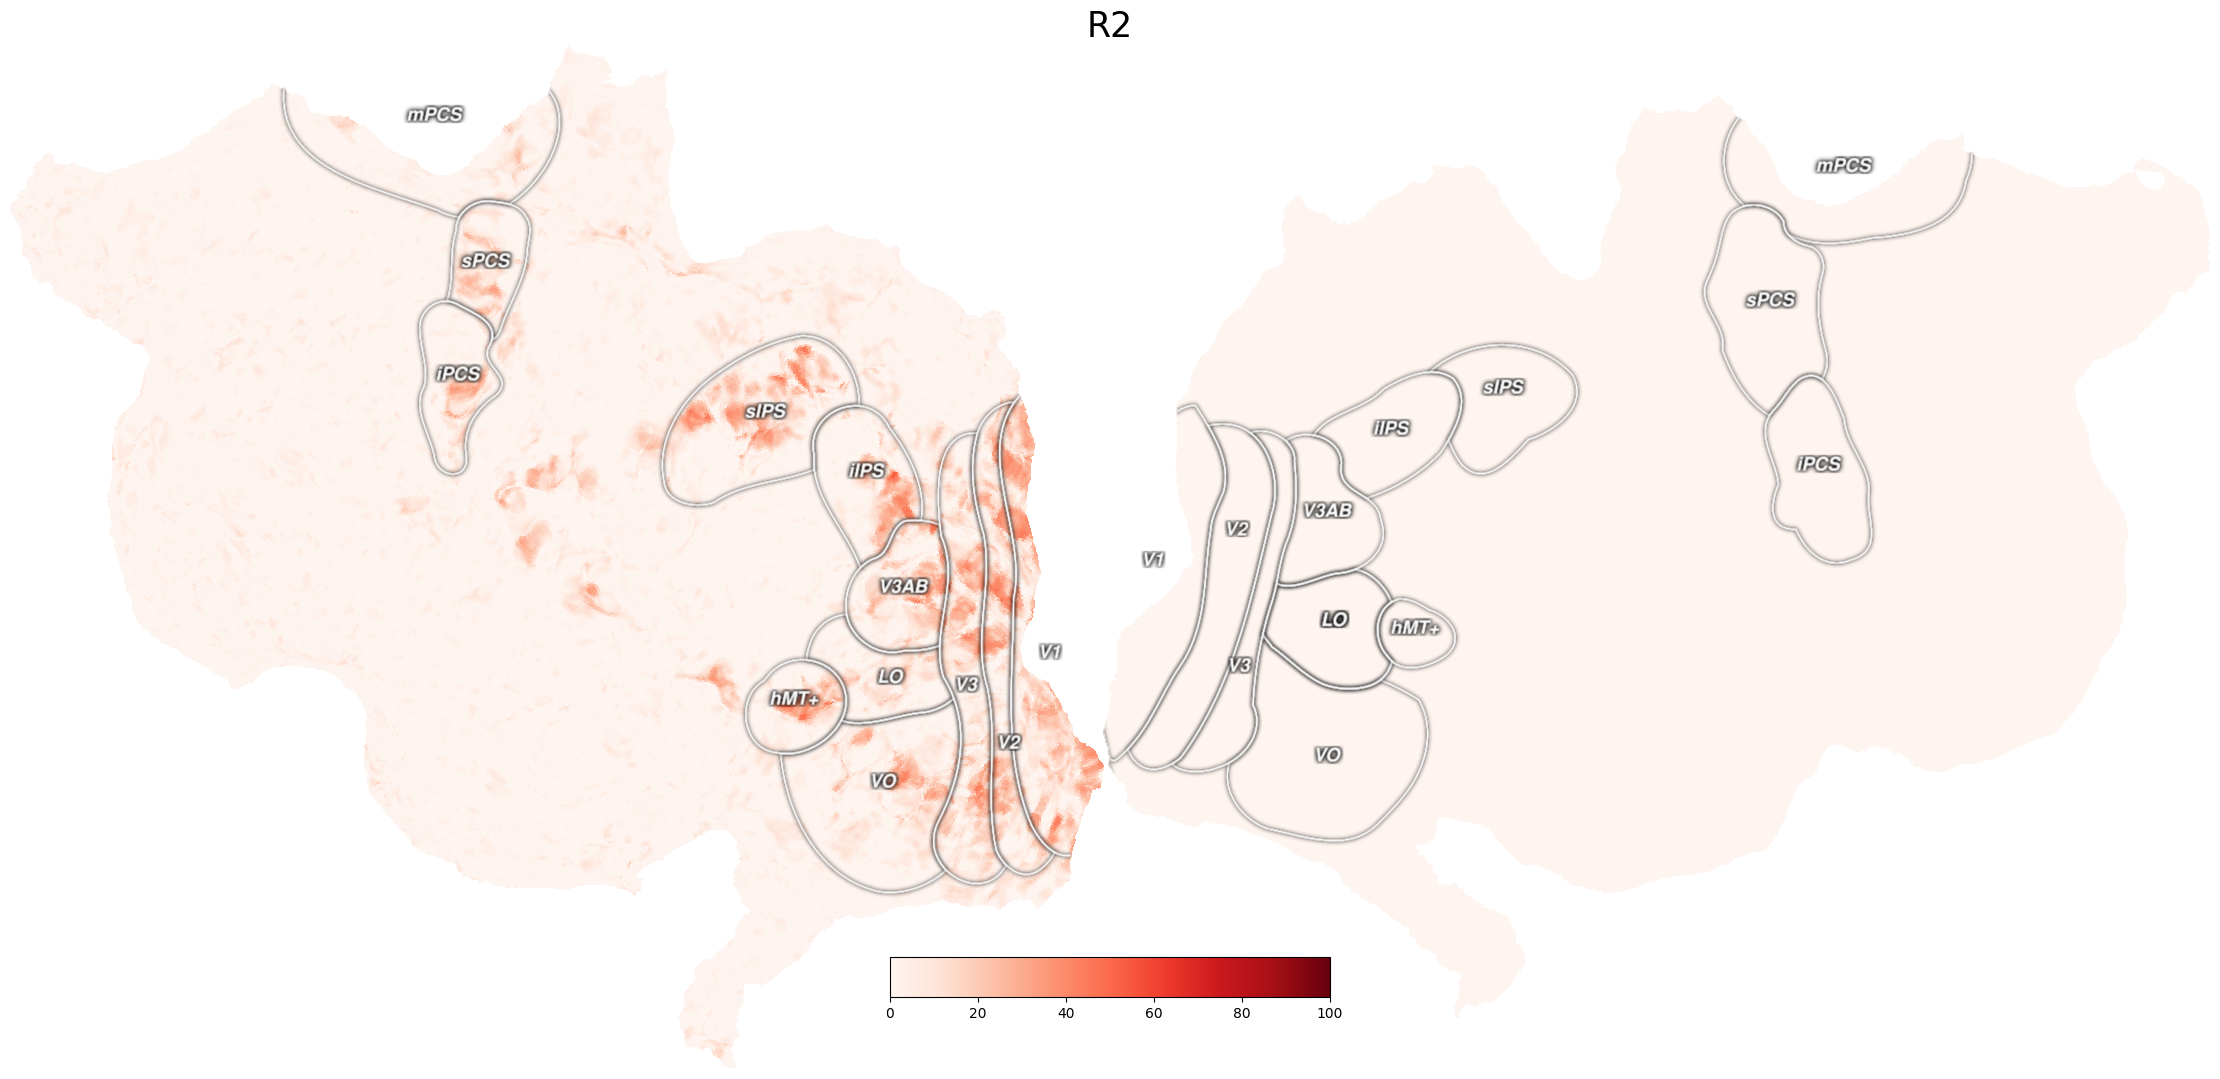

In [26]:
vertex_data = cortex.Vertex(np.array(results_glmsingle['typed']['R2'][:,0,0].T), subject, cmap='Reds', vmin=0, vmax=100)

cortex.quickshow(vertex_data, with_colorbar=True)
plt.title("R2", fontsize=25)
# plt.savefig('/Users/uriel/Downloads/mmp_atlas.pdf')
plt.show()

Unable to init server: Could not connect: Connection refused
Failed to get connection
** (inkscape:3072974): CRITICAL **: 15:59:11.385: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:3072974): CRITICAL **: 15:59:11.385: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:3072974): CRITICAL **: 15:59:11.385: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
** (inkscape:3072974): WARNING **: 15:59:11.577: Fonts dir '/usr/share/inkscape/fonts' does not exist and will be ignored.
Background RRGGBBAA: ffffff00
Area 0:0:2200.6:1024 exported to 2201 x 1024 pixels (96 dpi)


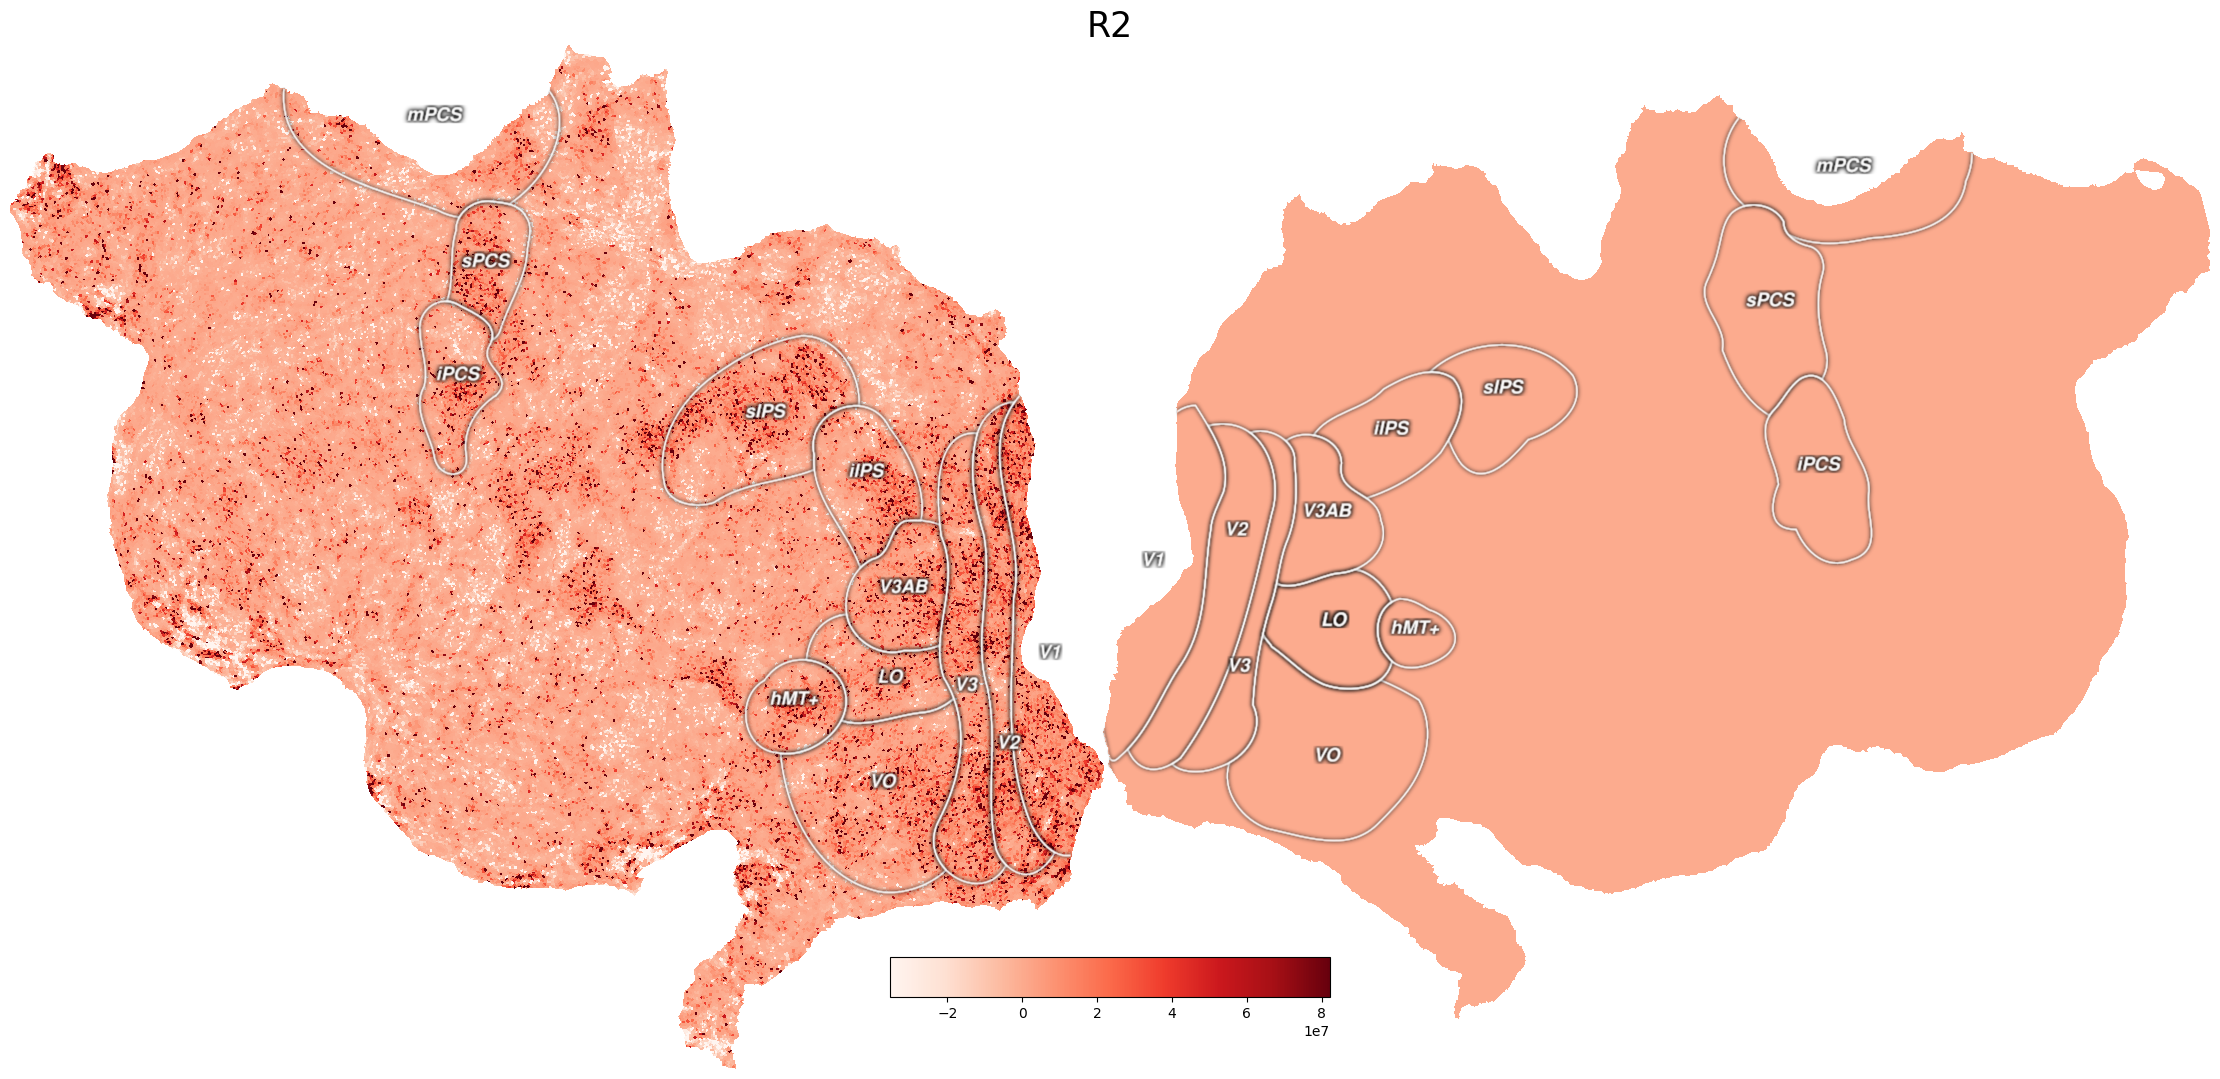

In [27]:
betas = np.nanmean(np.squeeze(results_glmsingle['typed']['betasmd']),1)

vertex_data = cortex.Vertex(betas, subject, cmap='Reds')

cortex.quickshow(vertex_data, with_colorbar=True)
plt.title("R2", fontsize=25)
# plt.savefig('/Users/uriel/Downloads/mmp_atlas.pdf')
plt.show()

In [28]:
fg = np.squeeze(results_glmsingle['typed']['betasmd'])

In [29]:
results_glmsingle['typed']['R2'].shape

(147618, 1, 1)

In [30]:
results_glmsingle['typed']['betasmd'].shape

(147618, 1, 1, 8)

# plot prediction 

In [32]:
# Import the designSINGLE
designSINGLE = np.load('{}/DESIGNINFO.npy'.format(outputdir),allow_pickle=True).item()['designSINGLE']
designSINGLE_run_01 = designSINGLE[0]

In [33]:
designSINGLE_run_01.shape

(208, 8)

In [34]:
#Find a voxel with highest variance explained of the ON-OFF model
R2 = results_glmsingle['typed']['R2']
ind = np.argmax(R2.flatten())

# Find vertex betas

betas = np.squeeze(results_glmsingle['typed']['betasmd'])[ind,:]

In [35]:
# acces to the library of HRF 
hrflib = getcanonicalhrflibrary(stimdur,TR).transpose()

# acces to wich HRF in the library the vertex to plot is fit 
hrfii = squish(results_glmsingle['typed']['HRFindex'],3)[ind]
meansignal = squish(results_glmsingle['typed']['meanvol'],3)[ind]

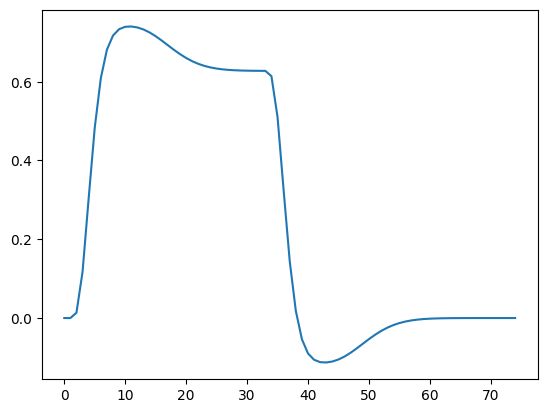

In [36]:
plt.plot(hrflib[:,hrfii])

In [37]:
myhrf    = hrflib[:,hrfii]
myhrf    = myhrf.reshape(1,len(myhrf))

# make convolution between the design matrix and the correct HRF
design0 = scipy.signal.convolve2d(designSINGLE_run_01.T,myhrf)
# cut the end to have the good lenght of the product of the convolution 
# design0 = design0[:,0:np.shape(designSINGLE_run_01)[0]]

In [38]:
designSINGLE_run_01.shape

(208, 8)

In [39]:
design0.shape

(8, 282)

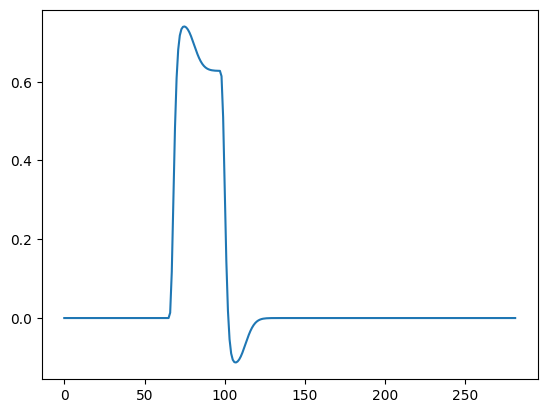

In [40]:
plt.plot(design0[1,:])

In [41]:
betatemp = betas/100 * meansignal

In [42]:
predicted = design0.T @ betatemp
# predicted = predicted - np.mean(predicted)

In [43]:
design0.shape

(8, 282)

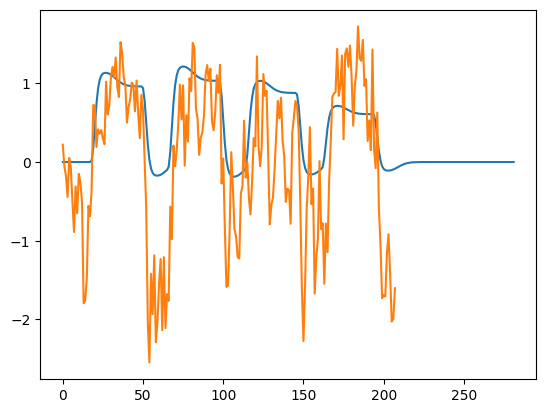

In [44]:
plt.plot(predicted)
plt.plot(data_dct_bold_L_run_1[:,ind])

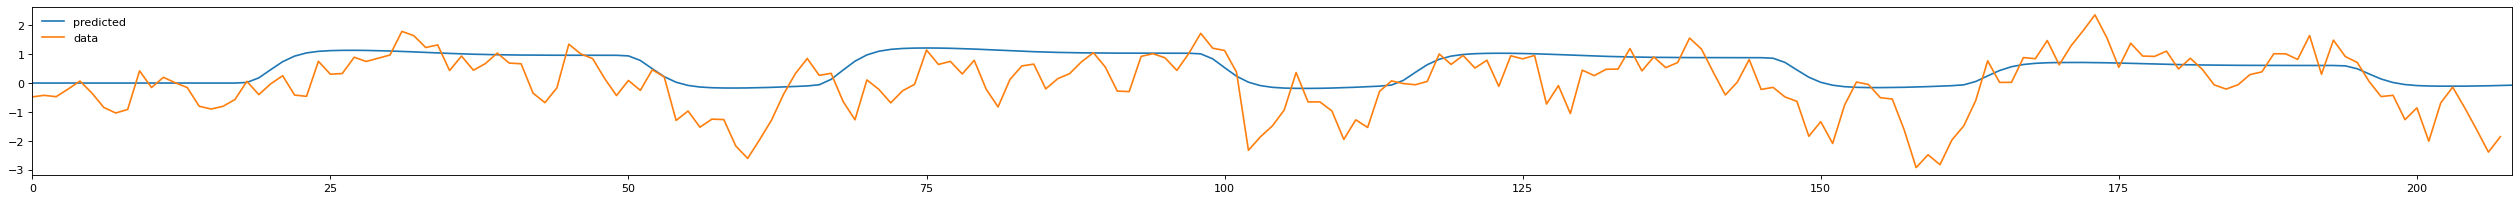

In [45]:
plt.figure(figsize=(40, 6), dpi=80)

ax = plt.subplot(2,1,1)
ax.plot(predicted)
ax.plot(data_dct_bold_L[:,ind])
l = ax.legend(('predicted', 'data'),loc=2,frameon=False)
plt.xlim((0,208))
plt.show()

In [46]:
#Find a voxel with highest variance explained of the ON-OFF model
R2 = results_glmsingle['typed']['R2']
ind = np.argmax(R2.flatten())

# Find voxel's betas
betas = np.squeeze(results_glmsingle['typed']['betasmd'])[ind,:]

In [47]:
betas.shape

(8,)

In [48]:
#find hrf estimated by GLMsingle
hrflib = getcanonicalhrflibrary(stimdur,TR).transpose()
hrfii = squish(results_glmsingle['typed']['HRFindex'],3)[np.nanargmax(R2.flatten())]
meansignal = squish(results_glmsingle['typed']['meanvol'],3)[np.nanargmax(R2.flatten())]

In [49]:

design = []
data = []

ptcs = []
tcs = []
for r in range(len(designSINGLE)):
    
    #data.append(Y['data'][0,r])
    # convert each run design matrix from sparse array to full numpy array, append
    mydesign = designSINGLE[r].transpose()
    mydata   = data_multi_run[r]
    myhrf    = hrflib[:,hrfii]
    myhrf    = myhrf.reshape(1,len(myhrf))


    # convolve HRF into design matrix
    design0 = scipy.signal.convolve2d(mydesign,myhrf).transpose();  
    design0 = design0[0:np.shape(mydesign)[1],:]
    betatemp = betas/100 * meansignal
    predicted = design0 @ betatemp
    
    #zeromean predicted tcs
    predicted = predicted - np.mean(predicted)
    ptcs = np.append(ptcs,predicted)

    tmp_tcs = mydata[ind,:]
    #zeromean data
    tmp_data = tmp_tcs - np.mean(tmp_tcs)
    tcs = np.append(tcs,tmp_data)




In [50]:
data_multi_run[0].shape

(147618, 1, 1, 208)

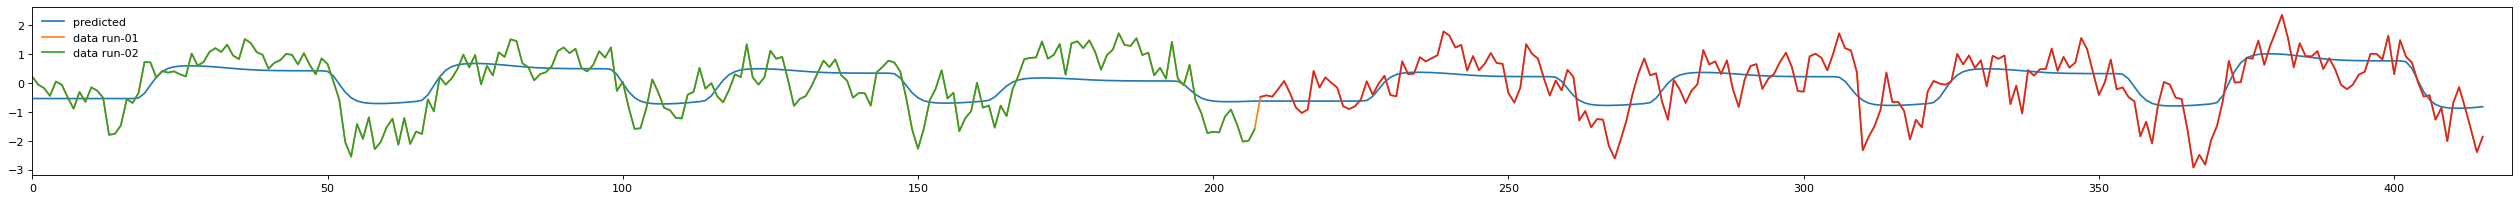

In [121]:
plt.figure(figsize=(40, 6), dpi=80)

ax = plt.subplot(2,1,1)
ax.plot(ptcs)
ax.plot(tcs)
ax.plot(np.squeeze(data_multi_run[0])[ind, :])
ax.plot(np.arange(208,416,1),np.squeeze(data_multi_run[1])[ind, :])
l = ax.legend(('predicted', 'data run-01', 'data run-02'),loc=2,frameon=False)
plt.xlim((0,420))
plt.show()

In [104]:
ind

4449

In [95]:
data_multi_run[0][ind, :],shape

(1, 1, 208)

In [52]:
glmsingle_pred = np.zeros()

TypeError: zeros() missing required argument 'shape' (pos 0)

## All vertx

In [113]:
betas_all = np.squeeze(results_glmsingle['typed']['betasmd']).T

In [114]:
# acces to wich HRF in the library the vertex to plot is fit 

hrf_index = np.squeeze(results_glmsingle['typed']['HRFindex'])
meansignal = np.squeeze(results_glmsingle['typed']['meanvol'])

In [115]:
# acces to the library of HRF 
hrflib = getcanonicalhrflibrary(stimdur,TR).transpose()


In [136]:
prediction_multi_run = []
for n_run in range(len(data_multi_run)):
# for n_run in range(1):
    print(n_run)
    designSINGLE_run = designSINGLE[n_run]
    
    betatemp_all = np.zeros_like(betas_all)
    prediction_all =  np.zeros((designSINGLE_run.shape[0], meansignal.shape[0]))
    for n_vertex in range(meansignal.shape[0]):
        hrf_vert = hrflib[:, hrf_index[n_vertex]]
        hrf_vert = hrf_vert.reshape(1,len(hrf_vert))
        # make convolution between the design matrix and the correct HRF
        design_convolv = scipy.signal.convolve2d(designSINGLE_run.T, hrf_vert)
        
        # cut the end to have the good lenght of the product of the convolution 
        design_convolv = design_convolv[:,0:np.shape(designSINGLE_run)[0]].T


        betatemp_all[:, n_vertex] = betas_all[:, n_vertex]/100 * meansignal[n_vertex]
        prediction_all[:, n_vertex] = design_convolv @ betatemp_all[:, n_vertex]

        prediction_all[:, n_vertex] = prediction_all[:, n_vertex] - np.mean(prediction_all[:, n_vertex])
    prediction_multi_run.append(prediction_all)

0
1


In [138]:
prediction_multi_run[0].shape

(208, 147618)

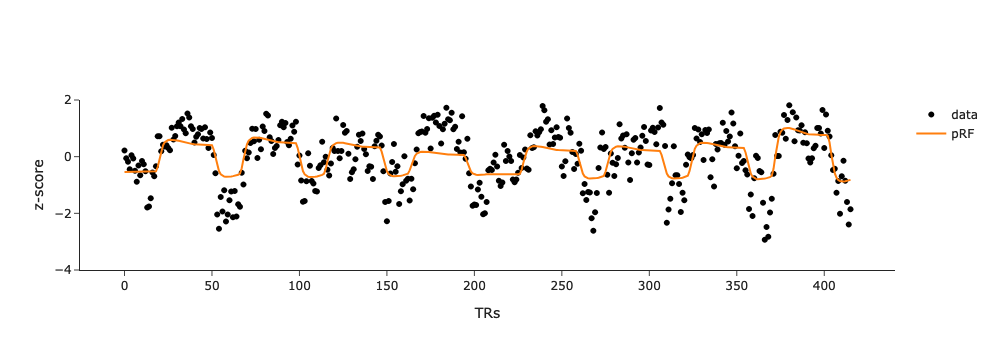

In [145]:
# plot best voxel for left hemisphere
ind = 4449

fig1 = go.Figure()
# plot data time series
data_concat = np.concatenate([np.squeeze(data_multi_run[0][ind, :]), np.squeeze(data_multi_run[1][ind, :])])

fig1.add_trace(go.Scatter(y=data_concat,
                          # y=np.squeeze(data_multi_run[0])[ind, :],
                         name='data', 
                         mode='markers', 
                          line=dict(color='black') 
                         ))

# plot pRF prediction
pred_concat = np.concatenate([prediction_multi_run[0][:,ind], prediction_multi_run[1][:,ind]])

fig1.add_trace(go.Scatter(y=pred_concat,
                          # y=prediction_all[:, ind],
                         name='pRF'))


# fig1.add_annotation(text='R<sup>2</sup>={:1.2f}'.format(prf_fit_data[r2_idx,num_vert_r2]),  
#                     x=198,  
#                     y=4,
#                     showarrow=False
#                    )

fig1.update_layout(template='simple_white', 
                   # title = '{} vertex time series for {} noise model'.format(num_vert,noise_model_2), 
                   xaxis_title = 'TRs', 
                   yaxis_title = 'z-score', 
                   showlegend= True,
                   height=350, 
                   yaxis=dict(title_standoff=0))

# fig1.update_xaxes(range=[0,bold_data.shape[0]])
# fig1.update_xaxes(range=[0,50])

fig1.update_yaxes(range=[-4,2])


fig1.show()

In [106]:
results_glmsingle['typed']['R2'][ind]

array([[54.43575]], dtype=float32)

In [150]:
results_glmsingle['typed']['R2run'][ind,0]

array([[55.28158 , 53.590908]], dtype=float32)

In [144]:
r2_score(data_concat,pred_concat)

0.48030931913501484

In [125]:
r2_score(np.squeeze(data_multi_run[0])[ind, :], prediction_all[:, ind])

0.47643584332808764

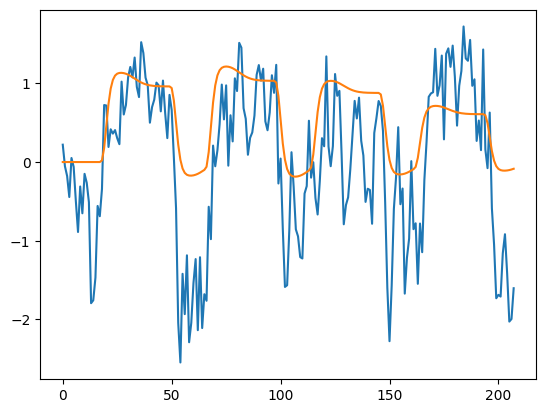

In [112]:
plt.plot(np.squeeze(data_multi_run[0])[ind, :])
plt.plot(prediction_all[:, ind])

In [80]:
r2_score( prediction_all[:, ind],np.squeeze(data_multi_run[0])[ind, :])

-2.4206402147420154

In [83]:
np.squeeze(data_multi_run[0])[ind, :].shape

(208,)

In [75]:
np.argmax(results_glmsingle['typed']['R2'])

4449

In [ ]:
a = betas_all[n_vertex]/100 * meansignal[n_vertex]

In [ ]:
betatemp_all[n_vertex, :].shape

In [ ]:
design0.T.shape

In [88]:
results_glmsingle['typed']['meanvol'].shape

(147618, 1, 1)

In [87]:
data_multi_run[0].shape

(147618, 1, 1, 208)